# Lab11-1 109021115

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [3]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

In [4]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


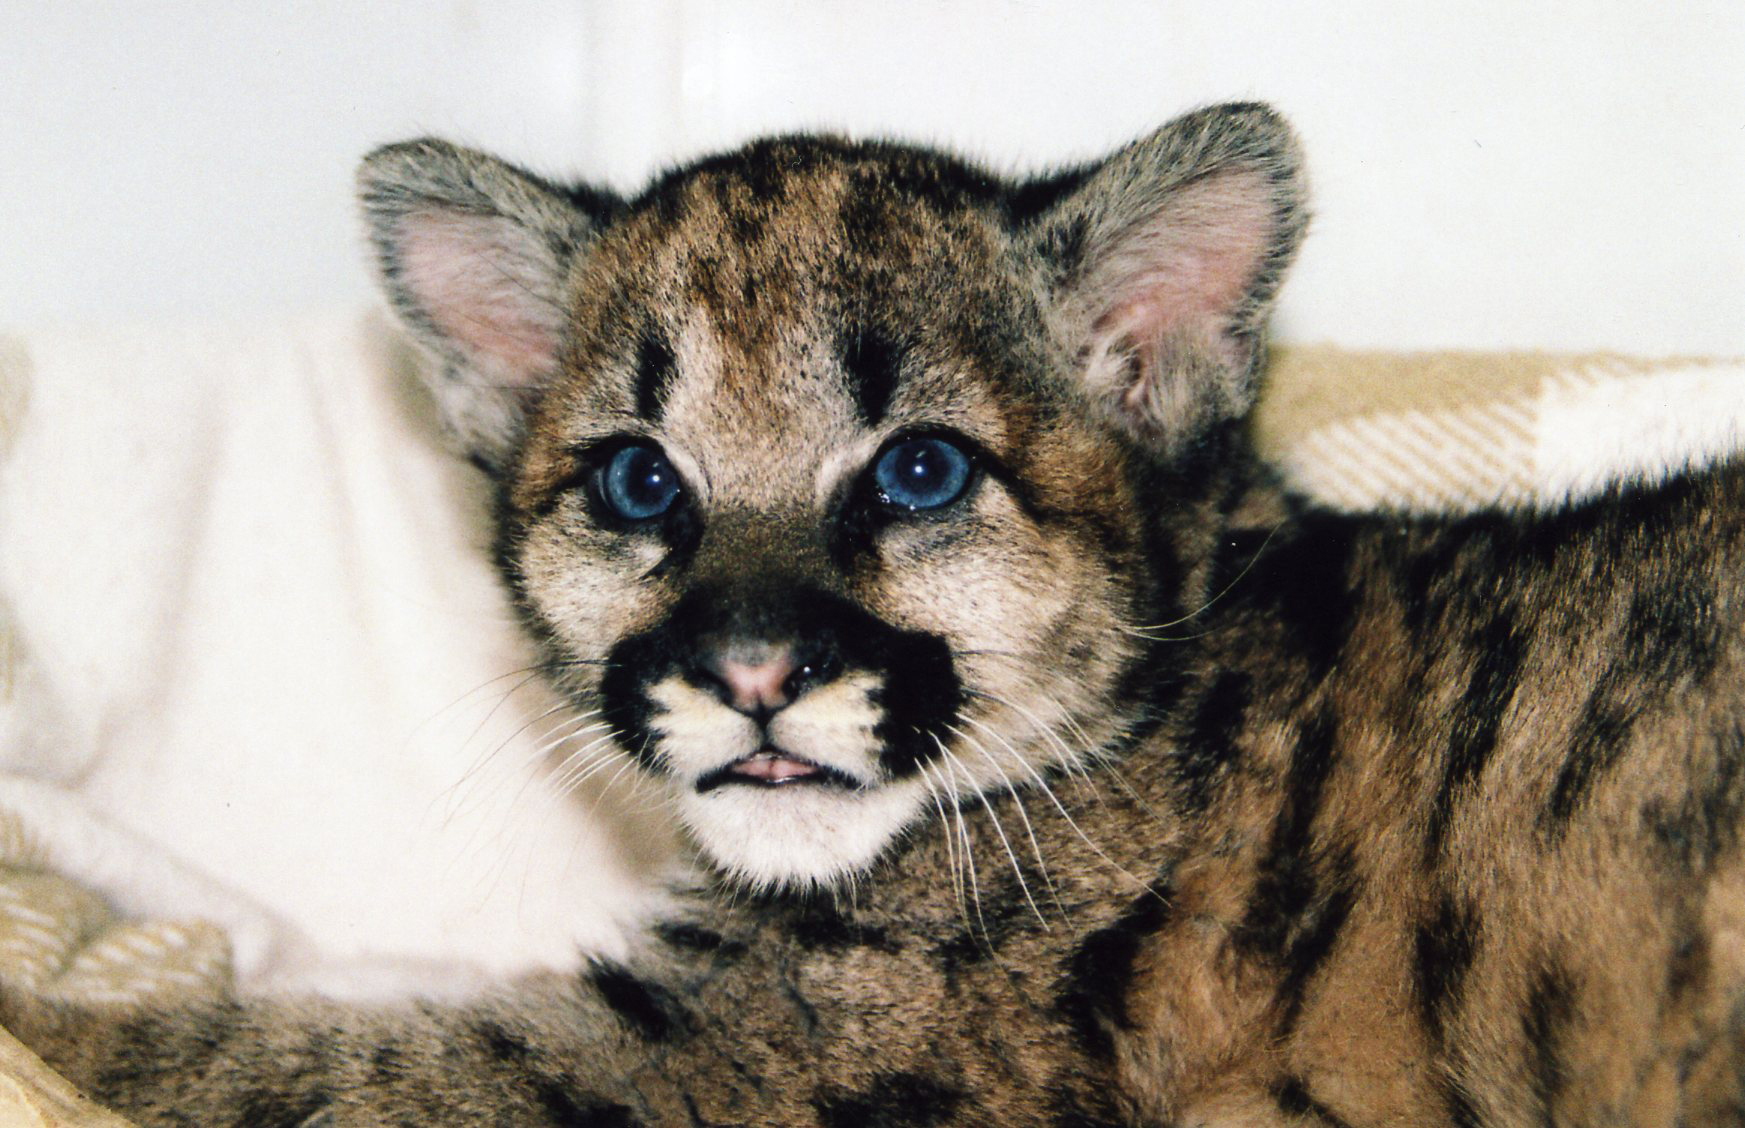

cougar


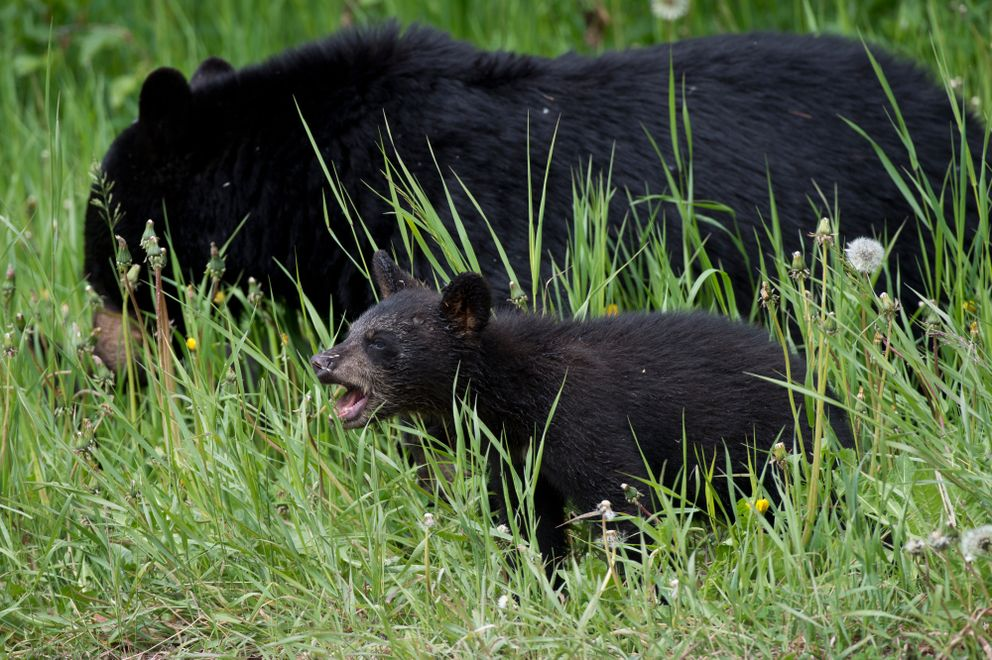

black_bear


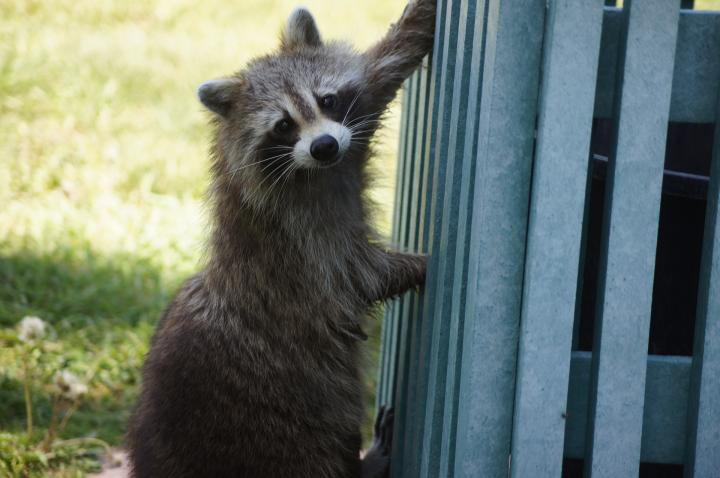

raccoon


In [5]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])

In [6]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [8]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [9]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [10]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [11]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [12]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [13]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [24]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[2.5636461e+04 6.2781000e-03]
 [2.5636467e+04 4.6334001e-03]], shape=(2, 2), dtype=float32) tf.Tensor(
[[20  0 -1]
 [20  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


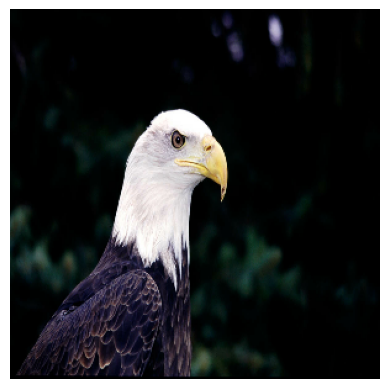

bald_eagle


In [44]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [16]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [17]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [18]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [20]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [21]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

## Naive

In [22]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  159.5487396
training:


100%|██████████| 5734/5734 [1:53:32<00:00,  1.19s/it]

testing:



100%|██████████| 1434/1434 [06:03<00:00,  3.94it/s]

Epoch 1, Loss: 4.8516, Accuracy: 11.1615, test Loss: 2.2940, test Accuracy: 11.2273
training:



100%|██████████| 5734/5734 [2:02:44<00:00,  1.28s/it]  

testing:



100%|██████████| 1434/1434 [09:11<00:00,  2.60it/s]

Epoch 2, Loss: 2.7784, Accuracy: 10.5337, test Loss: 2.3399, test Accuracy: 10.1813
training:



100%|██████████| 5734/5734 [2:13:59<00:00,  1.40s/it]  

testing:



100%|██████████| 1434/1434 [06:19<00:00,  3.77it/s]

Epoch 3, Loss: 2.4058, Accuracy: 9.9930, test Loss: 2.3247, test Accuracy: 10.1116
Execution time: 23512.079246


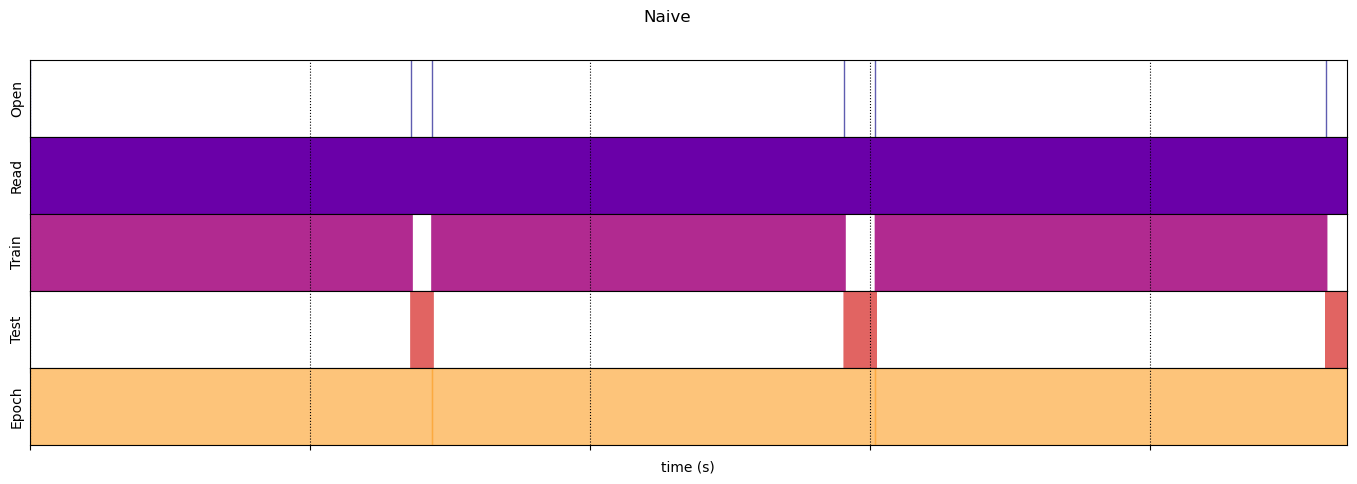

In [23]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

## Augmentation

In [91]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

# @tf.function
# def map_augment(image, label):
#     image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, IMAGE_DEPTH])
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
#     return image, label

def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, label.dtype) # tf.float32
        )
    return wrapper

@map_decorator
def map_fun_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    # record the enter time into map_fun()
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    # label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    # distorted_image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    # label = tf.one_hot(label,10)
    # distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

# dataset_train_augmentation = tf.data.Dataset.range(1). ...
# dataset_test_augmentation = tf.data.Dataset.range(1). ...

# Construct training Dataset with similar steps
dataset_train_augmentation = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_train)
    .map(map_fun_with_time)
    .shuffle(100)
    .batch(BATCH_SIZE, drop_remainder=True)
)

# Construct testing Dataset with similar steps
dataset_test_augmentation = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_test)
    .map(map_fun_test_with_time)
    .batch(BATCH_SIZE, drop_remainder=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64222467..0.6105099].


tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 2.7339354e+04  9.3272002e-03]
 [ 2.7339420e+04  8.0747996e-03]], shape=(3, 2), dtype=float32) tf.Tensor(
[[44  0 -1]
 [44  0  1]
 [44  0  1]], shape=(3, 3), dtype=int32)
(300, 300, 3)


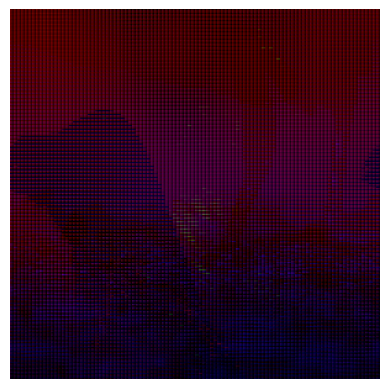

raven


In [77]:
# dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)

for steps, timings, counters, img, label in dataset_train_augmentation.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    # print(index_to_label[label[0].numpy()])
    # print(label[0])
    # print(label[0].numpy())
    print(index_to_label[int(np.argmax(label[0].numpy()))])

In [92]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  28800.442734
training:


100%|██████████| 89/89 [16:36<00:00, 11.19s/it]

testing:



100%|██████████| 22/22 [03:38<00:00,  9.95s/it]

Epoch 1, Loss: 6.2371, Accuracy: 13.3076, test Loss: 2.1792, test Accuracy: 19.1761


training:


100%|██████████| 89/89 [11:45<00:00,  7.92s/it]

testing:



100%|██████████| 22/22 [02:28<00:00,  6.74s/it]

Epoch 2, Loss: 2.2661, Accuracy: 15.1861, test Loss: 2.2085, test Accuracy: 16.8324
training:



100%|██████████| 89/89 [11:19<00:00,  7.64s/it]

testing:



100%|██████████| 22/22 [02:37<00:00,  7.14s/it]

Epoch 3, Loss: 2.2420, Accuracy: 14.7647, test Loss: 2.1056, test Accuracy: 19.3892
Execution time: 2905.3957247


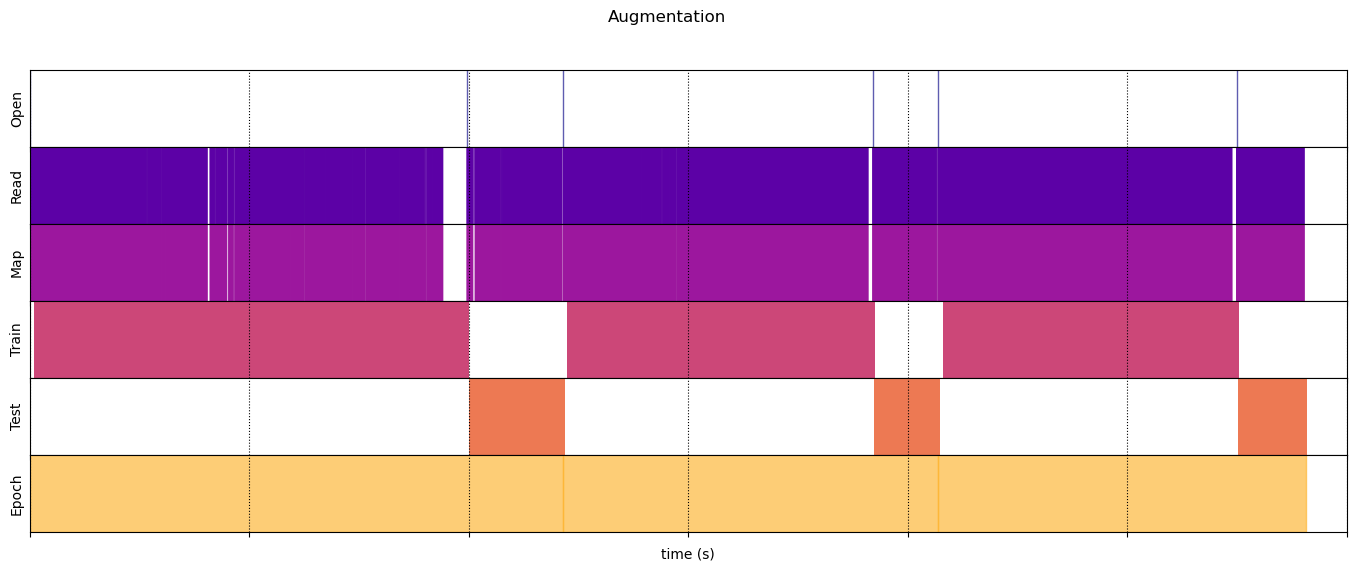

In [93]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

## Optimized

In [102]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

@map_decorator
def map_fun_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    # label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    # label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

# Construct optimized training dataset
dataset_train_optimized = (
    tf.data.Dataset.range(1)
    .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(100)
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(map_fun_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Construct optimized testing dataset
dataset_test_optimized = (
    tf.data.Dataset.range(1)
    .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(map_fun_test_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 3.3025469e+04  7.2865998e-03]
 [ 3.3055590e+04  3.1057732e+00]], shape=(3, 2), dtype=float32) tf.Tensor(
[[  66    0   -1]
 [  66    0 3056]
 [  66    0   -1]], shape=(3, 3), dtype=int32)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67341083..0.26196423].


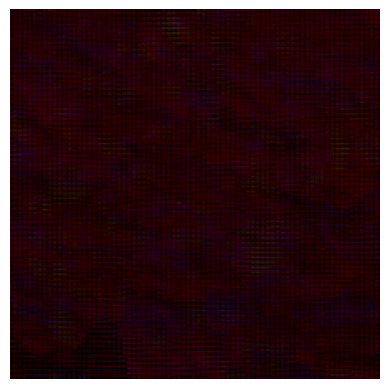

bald_eagle


In [98]:
for steps, timings, counters, img, label in dataset_train_optimized.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    # print(index_to_label[label[0].numpy()])
    # print(label[0])
    # print(label[0].numpy())
    print(index_to_label[int(np.argmax(label[0].numpy()))])

In [103]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  34285.1289411
training:


100%|██████████| 89/89 [19:53<00:00, 13.41s/it]

testing:



100%|██████████| 22/22 [04:36<00:00, 12.55s/it]

Epoch 1, Loss: 5.9257, Accuracy: 12.6229, test Loss: 2.2088, test Accuracy: 16.4773
training:



100%|██████████| 89/89 [15:26<00:00, 10.41s/it]

testing:



100%|██████████| 22/22 [02:10<00:00,  5.91s/it]

Epoch 2, Loss: 2.2433, Accuracy: 15.8532, test Loss: 2.1401, test Accuracy: 19.9574
training:



100%|██████████| 89/89 [10:11<00:00,  6.87s/it]

testing:



100%|██████████| 22/22 [02:12<00:00,  6.03s/it]


Epoch 3, Loss: 2.2229, Accuracy: 16.7837, test Loss: 2.1511, test Accuracy: 22.3722
Execution time: 3270.474597799999


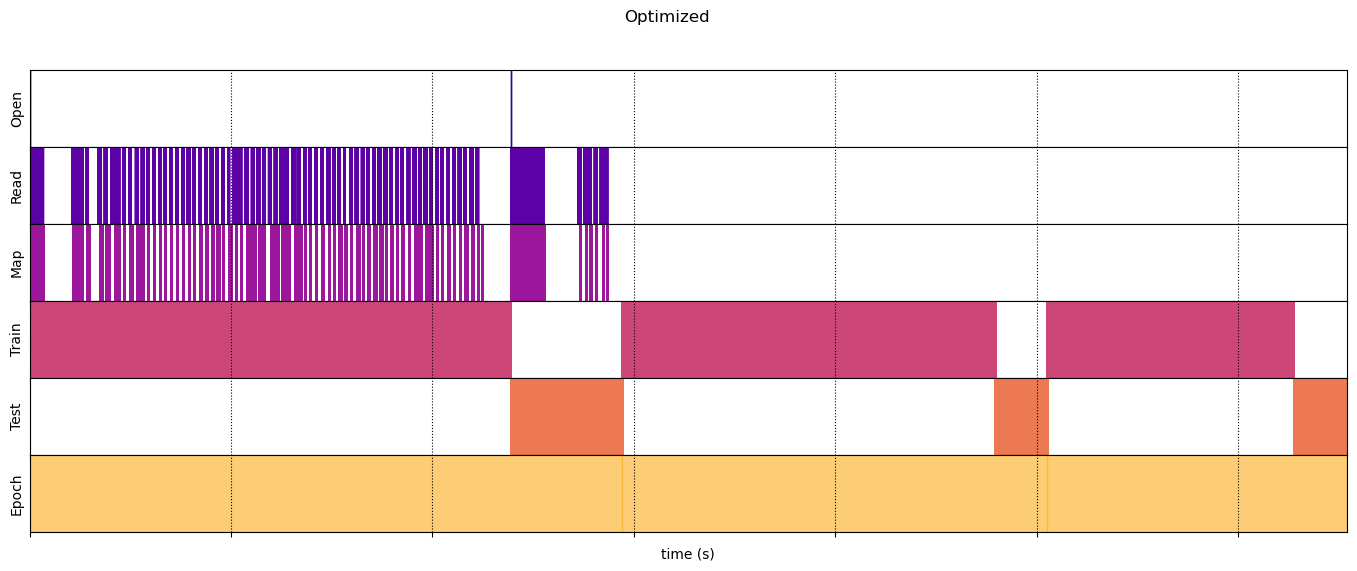

In [104]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=3000)

## Report

### Augmentation vs Naive
* In Augmentation model, I added some techniques: **crop, flip, brightness, contrast, standardize, shuffle, and batch, etc.**
* For performance(accuracy), Augmentation model is lot better than Naive one: **19.3892 vs 10.1116** (third epoch)
    * The reason is the extra techniques such as:
        * For each data itself: use **crop, flip, brightness, contrast, standardize, etc. methods**
        * For the whole dataset: use **map, shuffle, and batch methods**
* For time consumption, Augmentation model is less than Naive one: **2905.3957247 vs 23512.079246** (unit: seconds)
    * The resaon is mainly because augmentation model uses **batch** technique (BATCH_SIZE = 64), where the Naive one is set to BATCH_SIZE = 1

### Optimized vs Augmentation
* In Optimized model, I added some techniques: **prefatch, cache, interleave, and num_parallel_calls**
* For performance(accuracy), Optimized model is slightly better than Augmentation one: **22.3722 vs 19.3892** (third epoch)
    * The reason might just because **shuffle** technique happened to(碰巧) have increased more variance of data in each batch this time(compared to augmentation one), thus optimized model had less bias(compared to aumentation one), then better performance
    * In other words, I think the result is simply within the acceptable margin of error(結果在可接受誤差範圍內)
* For time consumption, Optimized model is a little more than Augmentation one: **3270.474597799999 vs 2905.3957247** (third epoch)
    * The reason may be because for me, the bottleneck is not I/O(extra techniques like **prefatch, cache, and interleave** save I/O time), instead, training(computing) process is the bottleneck, since in this lab, I used **CPU** for training